In [22]:
# imports 
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import tensorflow as tf
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image as keras_image
import random


# Read data

In [2]:
# Define Paths
dataset_dir = "Data"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 5002
Class: Moderate Dementia, Files Found: 488
Class: Non Demented, Files Found: 67222
Class: Very mild Dementia, Files Found: 13725


## Image from each classe

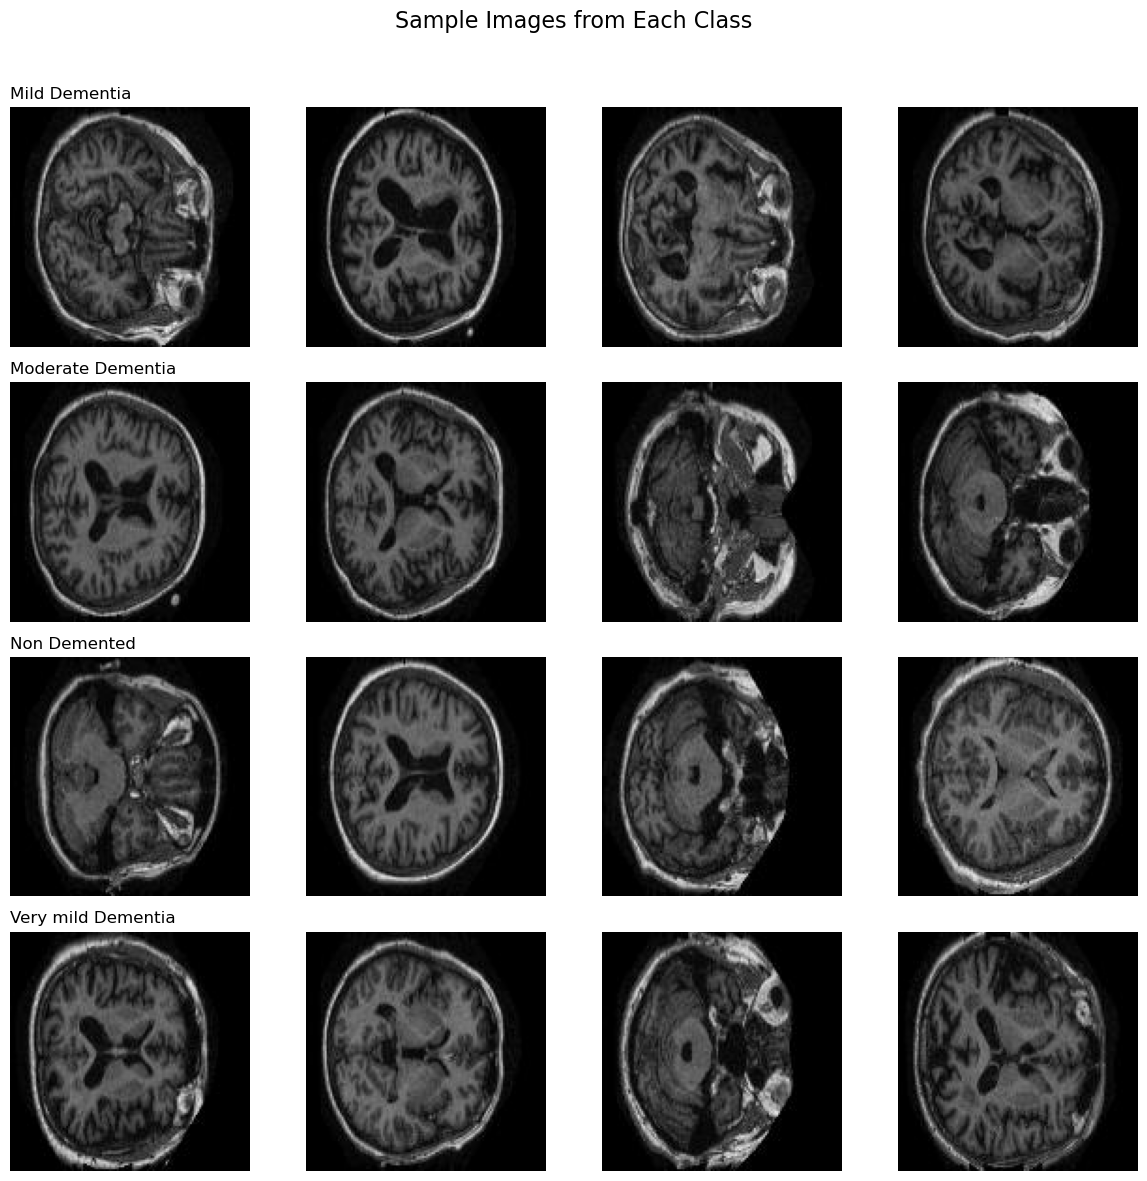

In [23]:
# Plot 4 images from each class
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for row, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = glob.glob(f"{class_dir}/*.jpg")
    
    if len(image_files) < 4:
        print(f"Warning: Less than 4 images in class '{class_name}'")
        selected_images = image_files  # Show all available
    else:
        selected_images = random.sample(image_files, 4)

    for col, img_path in enumerate(selected_images):
        img = Image.open(img_path).convert("RGB")
        axs[row, col].imshow(img)
        axs[row, col].axis("off")
        if col == 0:
            axs[row, col].set_title(class_name, fontsize=12, loc='left')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for title space
plt.show()

In [ ]:

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load Dataset
def load_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset


In [4]:
# Apply preprocessing so all datasets contain image tensors (not paths)
preprocessed_dataset = load_dataset(image_paths, labels)

# Split by class
class_2_dataset = preprocessed_dataset.filter(lambda img, label: tf.equal(label, 2)).shuffle(buffer_size=1000).take(15_000)
class_3_dataset = preprocessed_dataset.filter(lambda img, label: tf.equal(label, 3))
class_0_dataset = preprocessed_dataset.filter(lambda img, label: tf.equal(label, 0))
class_1_dataset = preprocessed_dataset.filter(lambda img, label: tf.equal(label, 1))

# Combine the datasets
final_dataset = (class_2_dataset
                 .concatenate(class_3_dataset)
                 .concatenate(class_0_dataset)
                 .concatenate(class_1_dataset))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
def CountDataset(dataset):
    label_counts = Counter()

    # Loop through dataset
    for _, lbl in dataset:
        class_index = int(lbl.numpy()) 
        label_counts[class_index] += 1

    # Print class distribution
    print("Final dataset class distribution:")
    for label, count in sorted(label_counts.items()):
        print(f"Class {label}: {count} images")
    return label_counts

In [6]:
final_dataset_counts = CountDataset(final_dataset)

2025-04-14 18:31:46.974816: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Final dataset class distribution:
Class 0: 5002 images
Class 1: 488 images
Class 2: 15000 images
Class 3: 13725 images


In [11]:
def visualize_class_distribution(label_counts):
    # Class names and file counts
    file_counts = [label_counts[i] for i in range(len(classes))]

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, file_counts, color=["#FF9999", "#FFCC99", "#99CCFF", "#CCFFCC"])
    plt.title("Image Count per Class", fontsize=16)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)

    # Add counts on top of bars, with dynamic padding
    for bar, count in zip(bars, file_counts):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + (yval * 0.03), f'{count}', ha='center', va='bottom', fontsize=10)

    # Set a slightly higher limit on Y-axis for better spacing
    plt.ylim(0, max(file_counts) * 1.15)

    plt.tight_layout()
    plt.show()


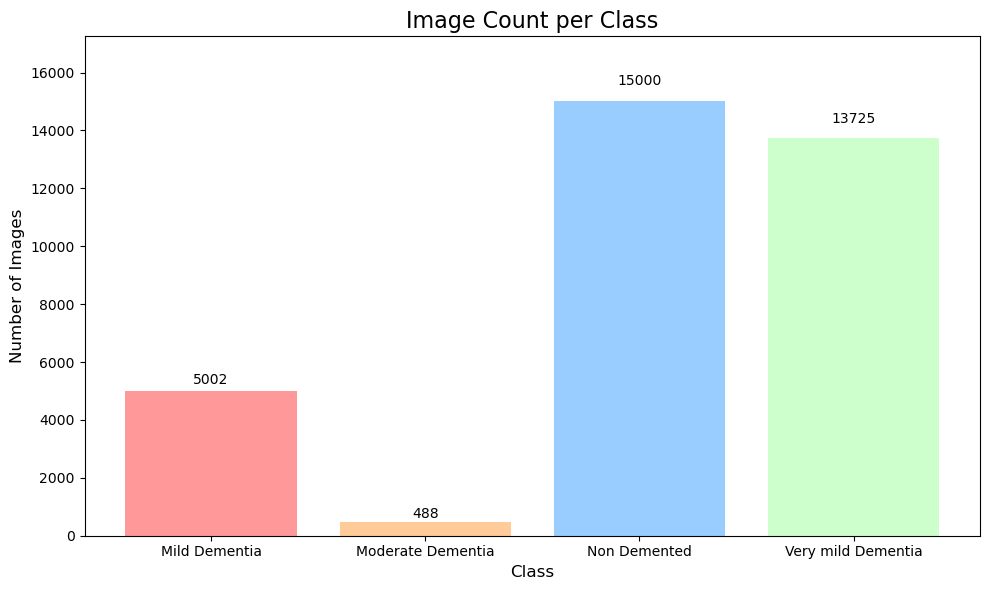

In [12]:
visualize_class_distribution(final_dataset_counts)

In [13]:
# Save the dataset to a folder structure
def save_dataset_to_folder(dataset, folder_path, class_names):
    os.makedirs(folder_path, exist_ok=True)

    for class_name in class_names:
        class_dir = os.path.join(folder_path, class_name)
        os.makedirs(class_dir, exist_ok=True)

    counter = [0] * len(class_names)  # To count how many images per class

    for image, label in dataset:
        # If label is one-hot encoded, convert to integer
        if tf.rank(label) > 0:
            label = tf.argmax(label, axis=-1)

        print(label)
        label = int(label.numpy())
        class_name = class_names[label]

        # Convert tensor to numpy and save as PNG
        image_np = image.numpy()
        if image_np.dtype != 'uint8':
            image_np = (image_np * 255).astype('uint8') 

        img = Image.fromarray(image_np)
        img_path = os.path.join(folder_path, class_name, f'{counter[label]}.jpg')
        img.save(img_path)

        counter[label] += 1

In [ ]:
save_dataset_to_folder(final_dataset, "final_dataset", classes)

# Read final dataset

In [14]:
# Define Paths
dataset_dir = "final_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 5002
Class: Moderate Dementia, Files Found: 488
Class: Non Demented, Files Found: 15000
Class: Very mild Dementia, Files Found: 13725


In [15]:
# Split data into training, testing and validation
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42,stratify=labels) # suffle by default and straity labels 
test_paths, val_paths, test_labels, val_labels = train_test_split(test_paths, test_labels, test_size=0.5, random_state=42,stratify=test_labels) # suffle by default and straity labels
# to keep the same class distribution

In [16]:
train_dataset = load_dataset(train_paths, train_labels)
val_dataset = load_dataset(val_paths, val_labels)
test_dataset = load_dataset(test_paths, test_labels)

## Visulaize train dataset

Final dataset class distribution:
Class 0: 3501 images
Class 1: 342 images
Class 2: 10500 images
Class 3: 9607 images


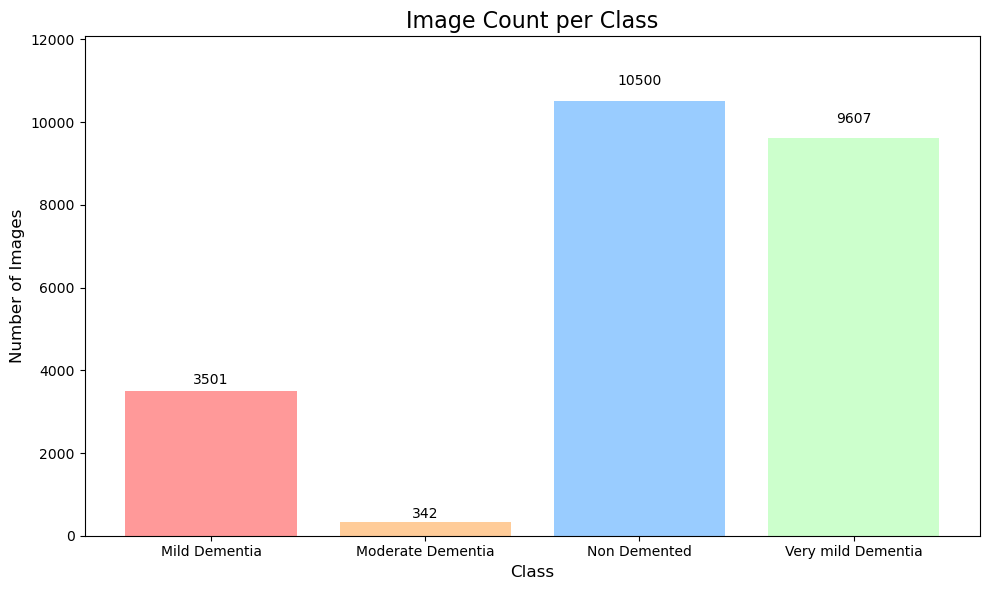

In [18]:
train_dataset_counts = CountDataset(train_dataset)
visualize_class_distribution(train_dataset_counts)

## Visulaize validation dataset

Final dataset class distribution:
Class 0: 751 images
Class 1: 73 images
Class 2: 2250 images
Class 3: 2059 images


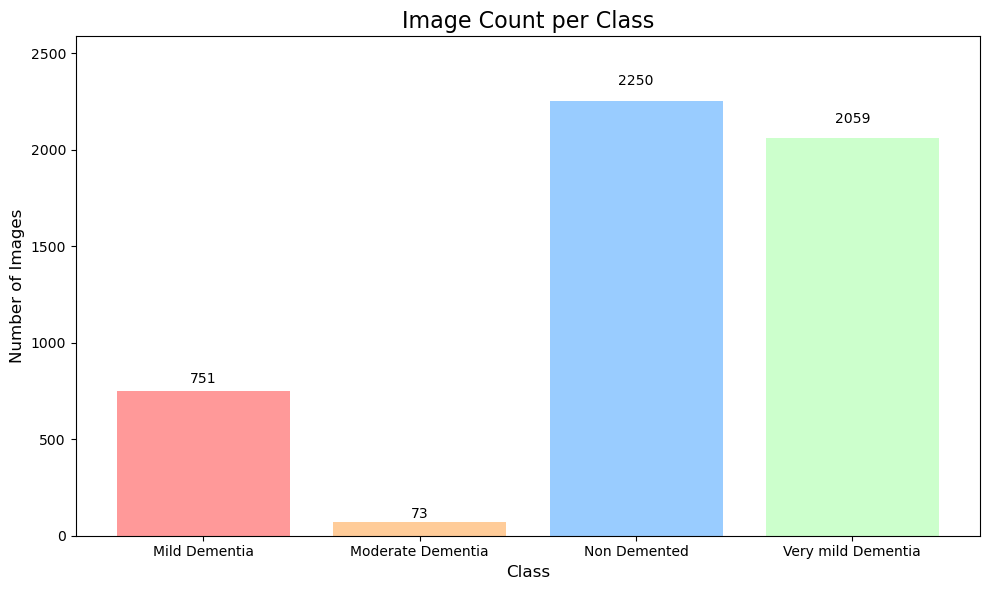

In [20]:
val_dataset_counts = CountDataset(val_dataset)
visualize_class_distribution(val_dataset_counts)

## Visulaize test dataset

Final dataset class distribution:
Class 0: 750 images
Class 1: 73 images
Class 2: 2250 images
Class 3: 2059 images


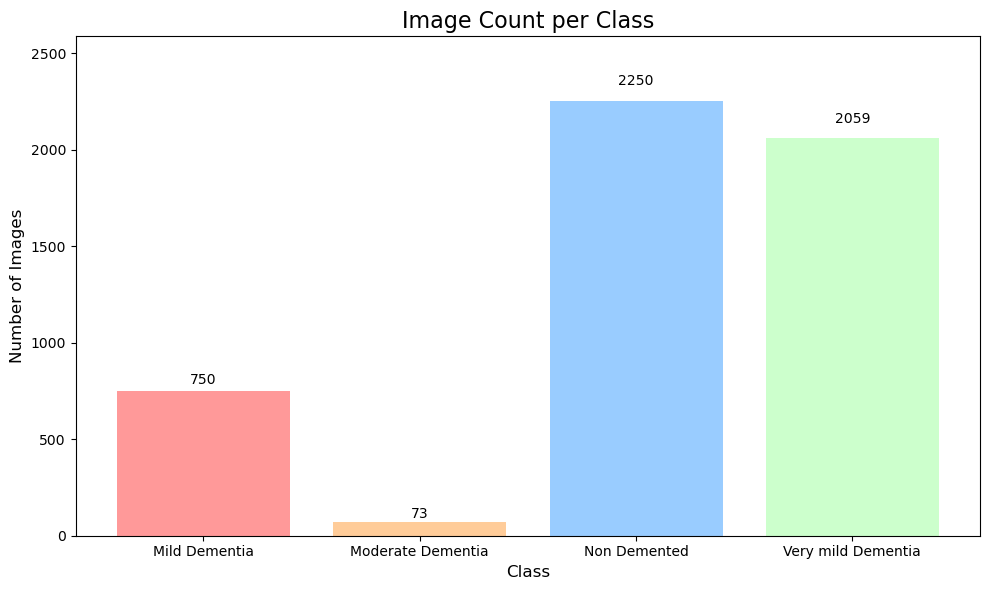

In [21]:
test_dataset_counts = CountDataset(test_dataset)
visualize_class_distribution(test_dataset_counts)

## Save datasets to folder structure

In [ ]:
save_dataset_to_folder(train_dataset, "train_dataset", classes)
save_dataset_to_folder(val_dataset, "val_dataset", classes)
save_dataset_to_folder(test_dataset, "test_dataset", classes)

# Data Agumentation

In [2]:
# Define Paths
dataset_dir = "train_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 3501
Class: Moderate Dementia, Files Found: 342
Class: Non Demented, Files Found: 10500
Class: Very mild Dementia, Files Found: 9607


In [3]:
path_train = "train_dataset"
path_val = "val_dataset"
val_datagenerator = ImageDataGenerator(rescale=1/255.)
train_datagenerator_augmentation = ImageDataGenerator(rescale = 1/255.,
                                                      rotation_range=20, #rotate the image
                                                      zoom_range = 0.2,#zoom the image
                                                      width_shift_range=0.2, #shift the image horizontally
                                                      height_shift_range=0.2, #shift the image vertically
                                                      horizontal_flip=True, #flip the image on horizontal axis
                                                      vertical_flip=True, #flip the image on vertical axis
                                                      shear_range = 0.2) #Shear the image



In [4]:
#Load data in from images and turn into batches
val_data = val_datagenerator.flow_from_directory(path_val,
                                                     target_size=(128,128),
                                                     batch_size=32,
                                                     class_mode='categorical'
                                                    )
train_data_augmented = train_datagenerator_augmentation.flow_from_directory(path_train,
                                                                            target_size=(128,128),
                                                                            batch_size=32,
                                                                            class_mode='categorical',
                                                                            shuffle=True)

Found 5133 images belonging to 4 classes.
Found 23950 images belonging to 4 classes.


In [ ]:
# Define the CNN model
def create_cnn(num_classes=4):

    model = keras.Sequential([
        # Convolutional Block 1
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2,2)),
        
        # Convolutional Block 2
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        # Convolutional Block 3
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        # Flatten & Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Reduce overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        # loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



In [6]:
# Create the model
cnn_model = create_cnn()

# Print model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [ ]:
# Train the model
cnn_model.fit(train_data_augmented, validation_data=val_data, epochs=300)

Epoch 1/300


2025-04-11 12:56:05.207796: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


749/749 [==============================] - 116s 154ms/step - loss: 0.9970 - accuracy: 0.5238 - val_loss: 0.9053 - val_accuracy: 0.5944
Epoch 2/300
749/749 [==============================] - 130s 174ms/step - loss: 0.8597 - accuracy: 0.6199 - val_loss: 0.8269 - val_accuracy: 0.6404
Epoch 3/300
749/749 [==============================] - 137s 182ms/step - loss: 0.8141 - accuracy: 0.6405 - val_loss: 0.7904 - val_accuracy: 0.6554
Epoch 4/300
749/749 [==============================] - 138s 184ms/step - loss: 0.7794 - accuracy: 0.6554 - val_loss: 0.7763 - val_accuracy: 0.6569
Epoch 5/300
749/749 [==============================] - 140s 187ms/step - loss: 0.7591 - accuracy: 0.6627 - val_loss: 0.7314 - val_accuracy: 0.6735
Epoch 6/300
749/749 [==============================] - 138s 184ms/step - loss: 0.7460 - accuracy: 0.6688 - val_loss: 0.6984 - val_accuracy: 0.6823
Epoch 7/300
749/749 [==============================] - 138s 185ms/step - loss: 0.7346 - accuracy: 0.6773 - val_loss: 0.6976 - val_

In [ ]:
# Save the Model
cnn_model.save("alzheimers_detection_final_model.h5")

In [9]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

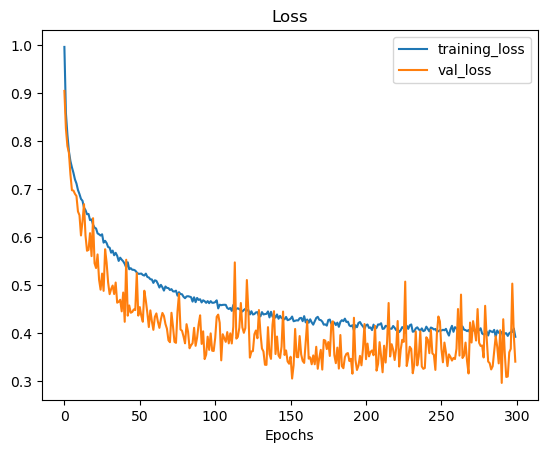

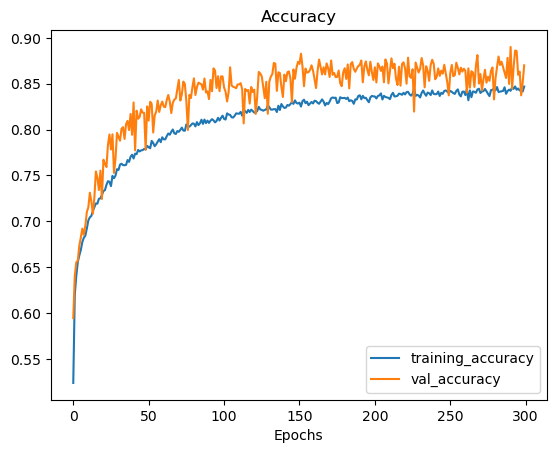

In [10]:
plot_loss_curves(cnn_model.history)

In [24]:
# Load the model
cnn_model = load_model("Modelos/alzheimers_detection_final_model.h5")

In [25]:
# Define Paths
dataset_dir = "val_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 751
Class: Moderate Dementia, Files Found: 73
Class: Non Demented, Files Found: 2250
Class: Very mild Dementia, Files Found: 2059


In [26]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Read the image from the path
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image to RGB
    image = tf.image.resize(image, [128, 128])  # Resize to (128, 128)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load and preprocess a list of images
def load_and_preprocess_images(image_paths):
    # Preprocess all images and store them in a list
    images = [preprocess_image(image_path) for image_path in image_paths]
    
    # Stack the images into a single batch (shape: (batch_size, 128, 128, 3))
    images_batch = tf.stack(images)
    
    return images_batch


test_data = load_and_preprocess_images(image_paths)

161/161 [==============================] - 6s 37ms/step
[0 3 0 ... 3 3 3]
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.86      0.87      0.86       750
 Moderate Dementia       0.87      0.89      0.88        73
      Non Demented       0.97      0.80      0.88      2250
Very mild Dementia       0.82      0.96      0.88      2059

          accuracy                           0.88      5132
         macro avg       0.88      0.88      0.88      5132
      weighted avg       0.89      0.88      0.88      5132



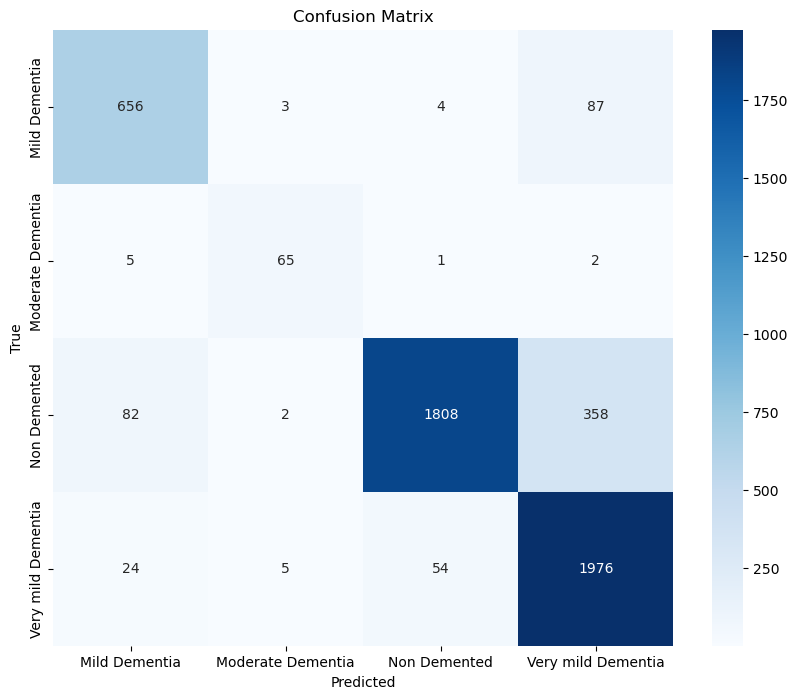

In [ ]:
y_true = labels
predictions = cnn_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
# Classification Report
class_names = classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
# Function to evaluate a single image
def evaluate_single_image(model, image_path, class_names, model_name="Model", target_size=(128, 128)):
    # Load and preprocess the image
    img = keras_image.load_img(image_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension
    img_array = tf.image.resize(img_array, [128, 128])  # Resize to (128, 128)
    img_array = img_array / 255.0  # Normalize if your model expects this
  

    # Predict
    preds = model.predict(img_array)
    print(preds)
    pred_class_index = np.argmax(preds[0])
    pred_class_name = class_names[pred_class_index]
    confidence = preds[0][pred_class_index]

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{model_name} Prediction:\n{pred_class_name} ({confidence:.2%})")
    plt.show()

    print(f"🔍 {model_name} - Predicted class: {pred_class_name} (Confidence: {confidence:.2%})")


1/1 [==============================] - 0s 17ms/step
[[0.03873253 0.80921924 0.09935064 0.05269761]]


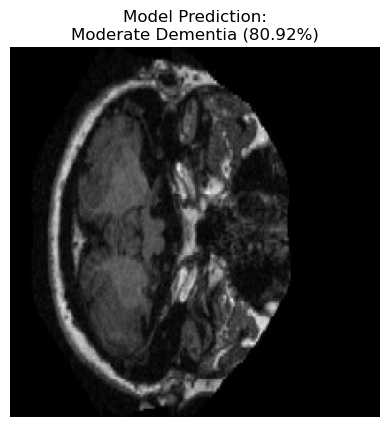

🔍 Model - Predicted class: Moderate Dementia (Confidence: 80.92%)


In [ ]:
evaluate_single_image(cnn_model, "Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_105.jpg", class_names=classes)